In [1]:
import math
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import scipy.signal as signal
import matplotlib.pyplot as plt

import plotly
from scipy.fftpack import ifft, fft
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [27]:
class session():
    # An object for storing data and metadata for one session of EEG recording
    def __init__(self, filename):
        self.f = filename
        
    def get_data(self, type='OpenBCI', fix=['OpenBCI-col_names']):
        # Create a pandas dataframe with channel data (data_chns)
        # fix:
        #   - "OpenBCI-col_names" - removes spaces from column names and makes channel number's 1-indexed
        if type == 'OpenBCI':
            f = open(self.f)
            self.meta = [f.readline() for i in range(4)]
            self.n_chns = int(self.meta[1][22:])
            self.fs = int(self.meta[2][15:18]) # sample rate

            self.data_chns = pd.read_csv(self.f, skiprows=[0,1,2,3])
            self.data_chns = self.data_chns.drop(columns=['Sample Index'])
            
            if 'OpenBCI-col_names' in fix:
                for i in range(self.n_chns):
                    self.data_chns = self.data_chns.rename(columns={self.data_chns.keys()[i]:'eeg_channel_'+str(i+1)})
            
            if 'Time' not in self.data_chns.keys():
                self.data_chns.reset_index(inplace=True)
                self.data_chns = self.data_chns.rename(columns={'index':'Time'})
                self.data_chns['Time'] = self.data_chns['Time'].divide(self.fs)
                    
    def crop_data(self, upto=-1, after=-1):
        # Crop the data upto or after a certain time in seconds
        if upto > 0:
            self.data_chns = self.data_chns.query('Time>=@upto')
            print('Removed data upto ' + str(upto) + ' seconds.\n')
        if after > 0:
            self.data_chns = self.data_chns.query('Time<=@after')
            print('Removed data after ' + str(upto) + ' seconds.\n')
    
    def make_fft(self, test_fq=-1):
        timestep = 1/self.fs
        self.fft = df()
        
        NFFT = 0
        exp = 1
        while 2**exp < len(self.data_chns):
            NFFT = 2**exp
            exp += 1
        
        self.fft['Frequency'] = np.fft.fftfreq(NFFT)
        self.fft['Frequency'] = np.fft.fftshift(self.fft['Frequency'])
        self.fft = self.fft.query('Frequency>=0').mul(self.fs)
#         self.fft['Frequency'] = self.fft['Frequency'].mul(self.fs)[NFFT//2:]
#         self.fft = self.fft.query('Frequency>=0')
        for i in range(self.n_chns):
#             print(len(self.fft['Frequency']))
#             print(len(np.fft.fft(self.data_chns['eeg_channel_'+str(i+1)], n=NFFT)[:(NFFT//2)]))
            self.fft['eeg_channel_'+str(i+1)] = (np.real(np.fft.fft(self.data_chns['eeg_channel_'+str(i+1)], n=NFFT))**2)[:NFFT//2]
        
        if test_fq > 0:
            if test_fq < self.fs/2:
                self.test_fq = test_fq
                self.data_chns[str(test_fq)+'_Hz_test_fq'] = [np.sin(2*np.pi*(i/self.fs*test_fq)) for i in range(len(self.data_chns))]
                self.fft[str(test_fq)+'_Hz_test_fq'] = (np.real(np.fft.fft(self.data_chns[str(test_fq)+'_Hz_test_fq'], n=NFFT))**2)[:NFFT//2]
            else:
                print('WARNING: The test frequency is too high to be detected at a sample rate of '+str(self.fs)+' Hz.')
                
    
    def plot(self, ver='', chns=[]):
        # Plot the data in different helpful ways
        if ver == 'pick-channels':
            fig = go.Figure(layout=go.Layout(title=go.layout.Title(text=str(len(chns)) + ' EEG Channels')
                        ))
            
            if len(chns) == 0:
                chns = range(1, self.n_chns + 1)
                print(chns)
            for i in range(len(chns)):
                fig.add_trace(go.Scatter(x=self.data_chns['Time'],
                                            y=self.data_chns['eeg_channel_'+str(chns[i])],
                                            mode='lines',
                                            name='EEG Ch.'+str(chns[i])))
            fig.show()

        if ver == 'all-chns-in-one':
            fig = go.Figure()
            for i in range(self.n_chns):
                fig.add_trace(go.Scatter(x=self.data_chns['Time'], y=self.data_chns['eeg_channel_'+str(i+1)],
                        mode='lines',
                        name='EEG Ch.'+str(i+1)))
            fig.show()
            
        if ver == 'chn-grid':
            if len(chns) == 0:
                fig = make_subplots(rows=self.n_chns, cols=1,
                                    vertical_spacing=0.01,
                                    subplot_titles=['EEG Channel '+str(i+1) for i in range(self.n_chns)])
                for i in range(self.n_chns):
                    fig.append_trace(go.Scatter(x=self.data_chns['Time'],
                                                y=self.data_chns['eeg_channel_'+str(i+1)],
                                                mode='lines',
                                                name='EEG Ch.'+str(i+1)),
                                                row=i+1,
                                                col=1)
                fig.update_layout(height=300*self.n_chns, width=800, title_text="Data by Channel")
                fig.show()
            else:
                fig = make_subplots(rows=len(chns), cols=1,
                                    vertical_spacing=0.2,
                                    subplot_titles=['EEG Channel '+str(i+1) for i in range(len(chns))])
                for i in range(len(chns)):
                    fig.append_trace(go.Scatter(x=self.data_chns['Time'],
                                                y=self.data_chns['eeg_channel_'+str(chns[i])],
                                                mode='lines',
                                                name='EEG Ch.'+str(chns[i])),
                                                row=i+1,
                                                col=1)
                fig.update_layout(height=300*len(chns), width=800, title_text="Data by Channel")
                fig.show()
                
        if ver == 'fq-old':
            for i in range(self.n_chns):
#                 plt.plot(self.fft['Frequency'], self.fft['eeg_channel_'+str(i+1)])
                plt.psd(self.data_chns['eeg_channel_'+str(i+1)], Fs=self.fs)
                plt.show()
        
        if ver == 'fq':
            if len(chns) == 0:
                fig = go.Figure()
                fig = make_subplots(rows=self.n_chns, cols=1,
                                    vertical_spacing=0.01,
                                    subplot_titles=['EEG Channel '+str(i+1) for i in range(self.n_chns)])
                for i in range(self.n_chns):
                    fig.append_trace(go.Scatter(x=self.fft['Frequency'], y=self.fft['eeg_channel_'+str(i+1)],
                            mode='lines',
                            name='EEG Ch.'+str(i+1)),
                            row=i+1,
                            col=1,)
                fig.update_layout(height=300*self.n_chns, width=800, title_text="Data by Channel")
                fig.show()
            else:
                fig = go.Figure()
                fig = make_subplots(rows=len(chns), cols=1,
                                    vertical_spacing=0.15,
                                    subplot_titles=['EEG Channel '+str(chns[i]) for i in range(len(chns))])
                for i in range(len(chns)):
                    fig.append_trace(go.Scatter(x=self.fft['Frequency'], y=self.fft['eeg_channel_'+str(chns[i])],
                            mode='lines',
                            name='EEG Ch.'+str(chns[i])),
                            row=i+1,
                            col=1,)
                fig.update_layout(height=300*len(chns), width=800, title_text="Data by Channel")
                fig.show()
                
        if ver == 'test-fft':
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=self.fft['Frequency'], y=self.fft[str(self.test_fq)+'_Hz_test_fq'],
                                     mode='lines',
                                     name=str(self.test_fq)+'_Hz_test_fq'))
            fig.show()
                

                

    def preprocess(self, hpf=0, lpf=0, rmv_avg=False, inplace=True):
        # Handle preprocessing to create a dataframe of processed data
        # High-pass filter = hpf
        # Low-pass filter = lpf
        # Remove Average = rmv_avg
        
        self.proc_data_chns = pd.DataFrame()
        self.proc_data_chns['Time'] = self.data_chns['Time']
        
        if rmv_avg:
            for i in range(self.n_chns):
                self.data_chns['eeg_channel_'+str(i+1)] = self.data_chns['eeg_channel_'+str(i+1)] - np.mean(self.data_chns['eeg_channel_'+str(i+1)])
                print(np.mean(self.data_chns['eeg_channel_'+str(i+1)]))

        
        if lpf > 0 and hpf > 0:
            for i in range(self.n_chns):
                b, a = signal.butter(2, lpf, 'low', fs=self.fs)
                self.proc_data_chns['eeg_channel_'+str(i+1)] = signal.filtfilt(b, a, self.data_chns['eeg_channel_'+str(i+1)])

                b, a = signal.butter(2, hpf, 'high', fs=self.fs)
                self.proc_data_chns['eeg_channel_'+str(i+1)] = signal.filtfilt(b, a, self.proc_data_chns['eeg_channel_'+str(i+1)])

        elif lpf > 0:
            for i in range(self.n_chns):
                b, a = signal.butter(2, lpf, 'low', fs=self.fs)
                self.proc_data_chns['eeg_channel_'+str(i+1)] = signal.filtfilt(b, a, self.data_chns['eeg_channel_'+str(i+1)])
        elif hpf > 0:
            for i in range(self.n_chns):
                b, a = signal.butter(2, hpf, 'high', fs=self.fs)
                self.proc_data_chns['eeg_channel_'+str(i+1)] = signal.filtfilt(b, a, self.data_chns['eeg_channel_'+str(i+1)])


        if inplace:
            self.data_chns = self.proc_data_chns
        return self.proc_data_chns

In [38]:
S1 = session('OpenBCI-RAW-2021-08-13_18-03-39.txt')
S1.get_data()
S1.crop_data(upto=1)
S1.preprocess(hpf=1, lpf=50, rmv_avg=True)

Removed data upto 1 seconds.

0.0
0.0
0.0
0.0
0.0
0.0
-1.1764074626721834e-10
-1.2254244402835243e-10
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


,Time,eeg_channel_1,eeg_channel_2,eeg_channel_3,eeg_channel_4,eeg_channel_5,eeg_channel_6,eeg_channel_7,eeg_channel_8,eeg_channel_9,eeg_channel_10,eeg_channel_11,eeg_channel_12,eeg_channel_13,eeg_channel_14,eeg_channel_15,eeg_channel_16
125,1.000,0.0,0.0,0.0,0.0,0.0,0.0,-60.624460,-44.798192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
126,1.008,0.0,0.0,0.0,0.0,0.0,0.0,3401.469577,4679.002222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
127,1.016,0.0,0.0,0.0,0.0,0.0,0.0,1439.618950,2220.867182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
128,1.024,0.0,0.0,0.0,0.0,0.0,0.0,2515.763191,3275.544494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129,1.032,0.0,0.0,0.0,0.0,0.0,0.0,2494.404531,3045.928836,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1260,10.080,0.0,0.0,0.0,0.0,0.0,0.0,-1188.225501,-1951.975265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1261,10.088,0.0,0.0,0.0,0.0,0.0,0.0,-1154.833707,-1871.219954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1262,10.096,0.0,0.0,0.0,0.0,0.0,0.0,-1237.490385,-1827.559693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1263,10.104,0.0,0.0,0.0,0.0,0.0,0.0,-2046.872184,-3098.307538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
S1.make_fft(test_fq=62)
S1.fft

,Frequency,eeg_channel_1,eeg_channel_2,eeg_channel_3,eeg_channel_4,eeg_channel_5,eeg_channel_6,eeg_channel_7,eeg_channel_8,eeg_channel_9,eeg_channel_10,eeg_channel_11,eeg_channel_12,eeg_channel_13,eeg_channel_14,eeg_channel_15,eeg_channel_16,62_Hz_test_fq
512,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.813334e+11,3.380237e+11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081079
513,0.122070,0.0,0.0,0.0,0.0,0.0,0.0,1.551038e+08,1.573771e+10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081079
514,0.244141,0.0,0.0,0.0,0.0,0.0,0.0,1.825044e+09,8.998486e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081079
515,0.366211,0.0,0.0,0.0,0.0,0.0,0.0,8.620874e+08,1.255944e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081079
516,0.488281,0.0,0.0,0.0,0.0,0.0,0.0,1.337849e+06,2.499969e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,61.889648,0.0,0.0,0.0,0.0,0.0,0.0,7.745507e+09,1.682619e+10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,213.452894
1020,62.011719,0.0,0.0,0.0,0.0,0.0,0.0,4.567661e+09,1.005087e+10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22886.348656
1021,62.133789,0.0,0.0,0.0,0.0,0.0,0.0,1.028701e+09,2.040239e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,220.902161
1022,62.255859,0.0,0.0,0.0,0.0,0.0,0.0,4.720275e+05,7.007195e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.843438


In [33]:
# plot
S1.plot(ver='fq', chns=[7,8])

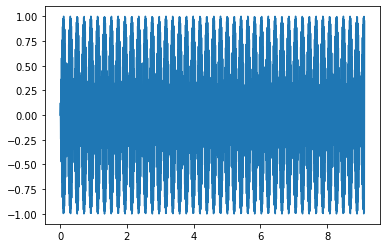

In [40]:
n =len(S1.data_chns)

fq = 60
fs = S1.fs

X = np.linspace(0, n, n)
Y = [np.sin(2*np.pi*(i/fs*fq)) for i in X]

plt.plot(X/fs, Y)

In [41]:
S1.data_chns['eeg_channel_1'] = Y

In [42]:
S1.make_fft()

In [43]:
# plot
S1.plot(ver='fq', chns=[1,7,8])